In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering,DBSCAN
from scipy.cluster import hierarchy
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [2]:
X_sc = pd.read_csv('./X_scaled.csv')

In [3]:
remove_list = ['Entidade de Previdência 3922_US_Yes',
               'Entidade de Previdência 4444_US_Yes',
               'Entidade de Previdência 4661_US_Yes',
               'Legal Classification_FI',
               'Legal Classification_FIC']
features = [col for col in X_sc.columns.values if col not in remove_list]

In [4]:
## FUNCION MODEL PARAMETERS
model_dic = {"kmeans": {"init_seed": [10],
                  "inits"  :  ["k-means++","random"],
                  "clusters_list": range(2,20),
                  "tol": 0.0001},
            "hierarchy": {"linkage_method":['complete','ward', 'single',
                           'centroid','median','weighted'],"t": range(4,15),
                          "criterion": "maxclust"},
           "Agglomerative": {"linkage_method":['complete','ward', 'single',
                             'centroid','median','weighted'],
                             'clusters_list':range(4,15),
                             "affinity": ['euclidean', 'l1', 'l2', 'manhattan',
                                      'cosine', 'precomputed'],
                         "clusters_list": range(4,10)},
            "dbscan": {"epslons":np.linspace(0.5,20,20),
                       "min_samples": [1,3,5,7,9,11,13,15,17,19,21,23,25,27,31]            
            }}
## FUNCION DATA FRAME PARAMETERS
df_dic = {'features': X_sc[features]}

In [10]:
def grid_clusters(df_dic, par_dic):
    result_dic = {"Data_frame" :[],
                  "model": [],
                  "inertia": [],
                  "silhouette": [],
                  "Numb_clusters": [],
                  "Cluster_counts": [],
                  "model_params": []
                  }
    # loop dataFrames
    for df_name, df_data in df_dic.items():
        X = df_data
        # loop models
        for n_model in par_dic.keys():
            if n_model == "kmeans":
                # loop centroid seeds
                for n_init_seed in par_dic['kmeans']['init_seed']:
                    # loop Method for initialization
                    for n_init_method in par_dic['kmeans']['inits']:
                            # loop number of clusters
                            for n_cluster in par_dic['kmeans']['clusters_list']:
                                kmeans = KMeans(n_clusters=n_cluster,
                                                init=n_init_method,
                                                n_init=n_init_seed,
                                                tol=par_dic['kmeans']['tol'],
                                                random_state=42)
                                kmeans.fit(X)
                                #Saving results in dic
                                result_dic['Data_frame'].append(df_name)
                                result_dic['model'].append(n_model)
                                result_dic['inertia'].append(kmeans.inertia_)
                                result_dic['silhouette'].append(silhouette_score(X, kmeans.labels_))
                                result_dic['Numb_clusters'].append(n_cluster)
                                result_dic['Cluster_counts'].append(list(pd.Series(kmeans.labels_).value_counts()))
                                result_dic['model_params'].append("n_init_Seed: "
                                                                  + str(n_init_seed) +
                                                                  " n_init_met: " + 
                                                                  str(n_init_method)) 
                                
            if n_model == "hierarchy":
                # loop linkage_method
                for n_link_met in par_dic['hierarchy']['linkage_method']:
                    for n_clusters in par_dic['hierarchy']['t']:
                        z = hierarchy.linkage(X, method=n_link_met)
                        cls = hierarchy.fcluster(z, n_clusters, "maxclust")
                        # Saving results in dic
                        result_dic['Data_frame'].append(df_name)
                        result_dic['model'].append(n_model)
                        result_dic['inertia'].append(0)
                        result_dic['silhouette'].append(silhouette_score(X, cls))
                        result_dic['Numb_clusters'].append(n_clusters)
                        result_dic['Cluster_counts'].append(list(pd.Series(cls).value_counts()))
                        result_dic['model_params'].append(n_link_met)
                        
            if n_model == "Agglomerative":
                # loop linkage criterion
                for n_link_met in par_dic['Agglomerative']['linkage_method']:
                    #loop number of clusters
                    for n_clusters in par_dic['Agglomerative']['clusters_list']:
                        # loop method to compute linkage
                        for n_affinity in par_dic['Agglomerative']['affinity']:
                            ac = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
                            ac.fit(X)
                            # Saving results in dic
                            result_dic['Data_frame'].append(df_name)
                            result_dic['model'].append(n_model)
                            result_dic['inertia'].append(0)
                            result_dic['silhouette'].append(silhouette_score(X, ac.labels_))
                            result_dic['Numb_clusters'].append(n_clusters)
                            result_dic['Cluster_counts'].append(list(pd.Series(ac.labels_).value_counts()))
                            result_dic['model_params'].append("Afin:" + n_affinity + ", Link:, " + n_link_met)
            
            if n_model == "dbscan":
                for e in par_dic['dbscan']['epslons']:
                    for samp in par_dic['dbscan']['min_samples']:
                        dbsc = DBSCAN(eps = e,
                                      min_samples = samp,
                                      metric='euclidean',
                                      leaf_size=30
                                      ).fit(X)
                        n_clusters = len(list(pd.Series(dbsc.labels_).value_counts()))
                        if n_clusters > 1 :      
                            result_dic['Data_frame'].append(df_name)
                            result_dic['model'].append(n_model)
                            result_dic['inertia'].append(0)
                            result_dic['silhouette'].append(silhouette_score(X, dbsc.labels_))
                            result_dic['Numb_clusters'].append(n_clusters)
                            result_dic['Cluster_counts'].append(list(pd.Series(dbsc.labels_).value_counts()))
                            result_dic['model_params'].append("Epslon:" + str(round(e,2)) + ", min_samp: " + str(samp))                           
    return pd.DataFrame(result_dic)

In [11]:
results = grid_clusters(df_dic,model_dic)

In [12]:
# Top agglomerative silhouette score
display(results[(results.model == 'Agglomerative')]\
.sort_values(by=['silhouette'],ascending = False).head(4))

# Top kmeans silhouette score
display(results[(results.model == 'kmeans')]\
.sort_values(by=['silhouette'],ascending = False).head(4))

# Top hierarchy silhouette score
display(results[(results.model == 'hierarchy')]\
.sort_values(by=['silhouette'],ascending = False).head(4))

# Top dbscan silhouette score
display(results[(results.model == 'dbscan') &
               (results.Numb_clusters >= 1)]\
.sort_values(by=['silhouette'],ascending = False).head(4))


,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
317,features,Agglomerative,0.0,0.212974,9,"[521, 410, 178, 144, 63, 36, 22, 4, 2]","Afin:precomputed, Link:, weighted"
209,features,Agglomerative,0.0,0.212974,9,"[521, 410, 178, 144, 63, 36, 22, 4, 2]","Afin:precomputed, Link:, single"
168,features,Agglomerative,0.0,0.212974,9,"[521, 410, 178, 144, 63, 36, 22, 4, 2]","Afin:euclidean, Link:, ward"
132,features,Agglomerative,0.0,0.212974,9,"[521, 410, 178, 144, 63, 36, 22, 4, 2]","Afin:euclidean, Link:, complete"


,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
0,features,kmeans,53747.464357,0.329951,2,"[1037, 343]",n_init_Seed: 10 n_init_met: k-means++
18,features,kmeans,53747.464357,0.329951,2,"[1037, 343]",n_init_Seed: 10 n_init_met: random
11,features,kmeans,27940.391553,0.261556,13,"[423, 408, 181, 97, 67, 44, 40, 40, 35, 34, 6,...",n_init_Seed: 10 n_init_met: k-means++
13,features,kmeans,25345.683189,0.259357,15,"[382, 356, 185, 122, 97, 45, 44, 40, 39, 35, 2...",n_init_Seed: 10 n_init_met: k-means++


,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
69,features,hierarchy,0.0,0.708087,4,"[1376, 2, 1, 1]",centroid
80,features,hierarchy,0.0,0.708087,4,"[1376, 2, 1, 1]",median
70,features,hierarchy,0.0,0.706333,5,"[1373, 3, 2, 1, 1]",centroid
91,features,hierarchy,0.0,0.703542,4,"[1375, 2, 2, 1]",weighted


,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
609,features,dbscan,0.0,0.748742,2,"[1372, 8]","Epslon:20.0, min_samp: 31"
594,features,dbscan,0.0,0.748742,2,"[1372, 8]","Epslon:18.97, min_samp: 31"
582,features,dbscan,0.0,0.748742,2,"[1372, 8]","Epslon:18.97, min_samp: 5"
583,features,dbscan,0.0,0.748742,2,"[1372, 8]","Epslon:18.97, min_samp: 7"


## Chosing good models based on:
1. Silhuete score 
2. Inertia( for kmeans)
3. cluster count distributuion

## DBSCAN

In [13]:
display(results[(results.model == 'dbscan') &
               (results.Numb_clusters >= 3 )]\
.sort_values(by=['silhouette'],ascending = False)[48:60])

,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
404,features,dbscan,0.0,0.338629,4,"[1276, 59, 26, 19]","Epslon:6.66, min_samp: 9"
409,features,dbscan,0.0,0.337659,4,"[1257, 78, 26, 19]","Epslon:6.66, min_samp: 19"
408,features,dbscan,0.0,0.337630,4,"[1272, 63, 26, 19]","Epslon:6.66, min_samp: 17"
407,features,dbscan,0.0,0.337630,4,"[1272, 63, 26, 19]","Epslon:6.66, min_samp: 15"
406,features,dbscan,0.0,0.337630,4,"[1272, 63, 26, 19]","Epslon:6.66, min_samp: 13"
415,features,dbscan,0.0,0.290017,22,"[1324, 22, 8, 3, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1,...","Epslon:7.68, min_samp: 1"
402,features,dbscan,0.0,0.216352,6,"[1281, 40, 26, 19, 8, 6]","Epslon:6.66, min_samp: 5"
403,features,dbscan,0.0,0.213575,5,"[1280, 47, 26, 19, 8]","Epslon:6.66, min_samp: 7"
401,features,dbscan,0.0,0.206998,9,"[1283, 27, 26, 19, 8, 8, 3, 3, 3]","Epslon:6.66, min_samp: 3"
356,features,dbscan,0.0,0.192055,29,"[795, 119, 83, 71, 71, 46, 33, 21, 17, 14, 11,...","Epslon:3.58, min_samp: 3"


In [14]:
## DBSCAN Parameters Chosen:
display(results.loc[[378,376]])
# saving labels 
dbsc_1 = DBSCAN(eps = 6.66, min_samples = 19).fit(X_sc[features]).labels_
# dbsc_2 = DBSCAN(eps = 3.58, min_samples = 5).fit(X_sc).labels_

,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
378,features,dbscan,0.0,0.152477,5,"[1124, 179, 38, 21, 18]","Epslon:4.61, min_samp: 17"
376,features,dbscan,0.0,0.122597,6,"[1126, 161, 39, 21, 19, 14]","Epslon:4.61, min_samp: 13"


## Hierarchy

In [15]:
display(results[(results.model == 'hierarchy') &
               (results.Numb_clusters <10 )]\
.sort_values(by=['silhouette'],ascending = False)[20:50])

,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
74,features,hierarchy,0.0,0.579050,9,"[1369, 3, 2, 1, 1, 1, 1, 1, 1]",centroid
85,features,hierarchy,0.0,0.579050,9,"[1369, 3, 2, 1, 1, 1, 1, 1, 1]",median
63,features,hierarchy,0.0,0.579050,9,"[1369, 3, 2, 1, 1, 1, 1, 1, 1]",single
96,features,hierarchy,0.0,0.543268,9,"[1363, 6, 4, 2, 1, 1, 1, 1, 1]",weighted
36,features,hierarchy,0.0,0.436480,4,"[1326, 51, 2, 1]",complete
38,features,hierarchy,0.0,0.396597,6,"[1325, 47, 4, 2, 1, 1]",complete
37,features,hierarchy,0.0,0.396507,5,"[1326, 47, 4, 2, 1]",complete
41,features,hierarchy,0.0,0.376805,9,"[1316, 45, 6, 4, 3, 2, 2, 1, 1]",complete
40,features,hierarchy,0.0,0.373700,8,"[1319, 45, 6, 4, 2, 2, 1, 1]",complete
39,features,hierarchy,0.0,0.369890,7,"[1325, 45, 4, 2, 2, 1, 1]",complete


In [16]:
## Hierarchy Parameters:
display(results.loc[[47]])
# saving labels 
z = hierarchy.linkage(X_sc[features], method="ward")
hierarchy_1 = hierarchy.fcluster(z, 9, "maxclust")

,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
47,features,hierarchy,0.0,0.173866,4,"[620, 410, 348, 2]",ward


## Agglomerative

In [17]:
display(results[(results.model == 'Agglomerative')& (results.Numb_clusters <10)]\
.sort_values(by=['silhouette'],ascending = False)[120:160])

,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
131,features,Agglomerative,0.0,0.200451,8,"[521, 410, 200, 144, 63, 36, 4, 2]","Afin:precomputed, Link:, complete"
237,features,Agglomerative,0.0,0.200451,8,"[521, 410, 200, 144, 63, 36, 4, 2]","Afin:manhattan, Link:, centroid"
238,features,Agglomerative,0.0,0.200451,8,"[521, 410, 200, 144, 63, 36, 4, 2]","Afin:cosine, Link:, centroid"
239,features,Agglomerative,0.0,0.200451,8,"[521, 410, 200, 144, 63, 36, 4, 2]","Afin:precomputed, Link:, centroid"
270,features,Agglomerative,0.0,0.200451,8,"[521, 410, 200, 144, 63, 36, 4, 2]","Afin:euclidean, Link:, median"
236,features,Agglomerative,0.0,0.200451,8,"[521, 410, 200, 144, 63, 36, 4, 2]","Afin:l2, Link:, centroid"
162,features,Agglomerative,0.0,0.200451,8,"[521, 410, 200, 144, 63, 36, 4, 2]","Afin:euclidean, Link:, ward"
163,features,Agglomerative,0.0,0.200451,8,"[521, 410, 200, 144, 63, 36, 4, 2]","Afin:l1, Link:, ward"
203,features,Agglomerative,0.0,0.200451,8,"[521, 410, 200, 144, 63, 36, 4, 2]","Afin:precomputed, Link:, single"
198,features,Agglomerative,0.0,0.200451,8,"[521, 410, 200, 144, 63, 36, 4, 2]","Afin:euclidean, Link:, single"


In [18]:
display(results.loc[[112]])
# Agglomerative parameters
ac = AgglomerativeClustering(n_clusters=5, affinity='cosine', linkage='complete')
ac.fit(X_sc[features])
print(silhouette_score(X_sc[features], ac.labels_))
agglomerative_1 = ac.labels_

,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
112,features,Agglomerative,0.0,0.195529,5,"[584, 410, 348, 36, 2]","Afin:cosine, Link:, complete"


0.09873823145299512


## Kmeans

In [19]:
display(results[(results.model == 'kmeans') & (results.Numb_clusters <10) ]\
.sort_values(by=['inertia'],ascending = True).sort_values(by=['silhouette'],ascending = False).\
        head(40))

,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
0,features,kmeans,53747.464357,0.329951,2,"[1037, 343]",n_init_Seed: 10 n_init_met: k-means++
18,features,kmeans,53747.464357,0.329951,2,"[1037, 343]",n_init_Seed: 10 n_init_met: random
7,features,kmeans,34098.192596,0.242477,9,"[519, 439, 310, 42, 35, 22, 8, 3, 2]",n_init_Seed: 10 n_init_met: k-means++
25,features,kmeans,35174.989874,0.225263,9,"[538, 422, 165, 96, 51, 40, 39, 26, 3]",n_init_Seed: 10 n_init_met: random
24,features,kmeans,36810.350929,0.223911,8,"[538, 426, 179, 117, 51, 40, 26, 3]",n_init_Seed: 10 n_init_met: random
5,features,kmeans,38072.976259,0.219536,7,"[521, 426, 299, 54, 43, 35, 2]",n_init_Seed: 10 n_init_met: k-means++
4,features,kmeans,40523.102487,0.217403,6,"[560, 453, 327, 35, 3, 2]",n_init_Seed: 10 n_init_met: k-means++
22,features,kmeans,41323.581853,0.217263,6,"[538, 485, 288, 40, 26, 3]",n_init_Seed: 10 n_init_met: random
6,features,kmeans,35693.246235,0.216597,8,"[517, 426, 201, 152, 44, 35, 3, 2]",n_init_Seed: 10 n_init_met: k-means++
3,features,kmeans,42942.765100,0.211827,5,"[561, 453, 329, 35, 2]",n_init_Seed: 10 n_init_met: k-means++


In [20]:
# Kmeans parameters
display(results.loc[[3]])
kmeans_1 = KMeans(n_clusters=5, init='k-means++',
                random_state=42).fit(X_sc[features])
print(silhouette_score(X_sc[features], kmeans_1.labels_))
kmeans_1 = kmeans_1.labels_

,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
3,features,kmeans,42942.7651,0.211827,5,"[561, 453, 329, 35, 2]",n_init_Seed: 10 n_init_met: k-means++


0.21182736181173883


In [21]:
kmeans_2 = KMeans(n_clusters=9, init='k-means++',
                random_state=42).fit(X_sc[features])
silhouette_score(X_sc[features], kmeans_2.labels_)

0.2424770288901744

In [22]:
# raw_df.groupby(['dbscan_s9_e_4.5'])[["Return_6m",'Return_12m','Return_24m']].agg([np.median])

In [23]:
## Checking number of Cluster using the elbow method

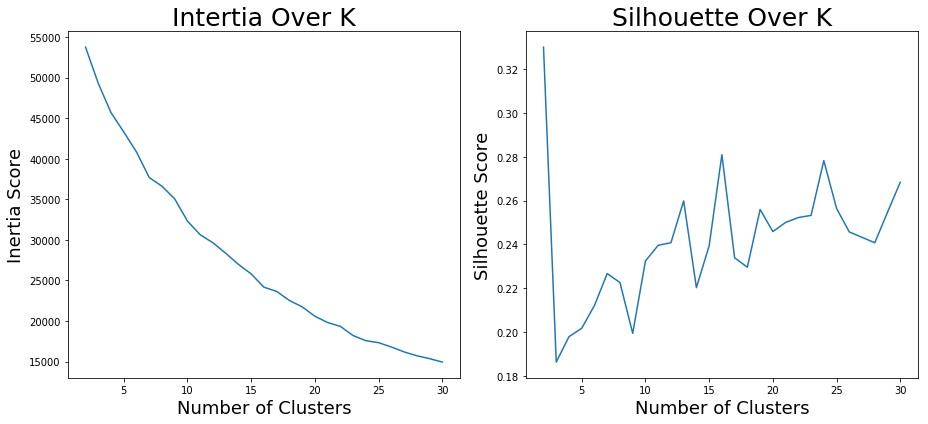

In [24]:
from sklearn.metrics import silhouette_score 
from sklearn.model_selection import ParameterGrid

class eval_kmeans:
    
    param_grid = dict(n_clusters=np.arange(2, 31))
    model = None
    scores = []
    
    def __init__(self, param_grid = None):
        
        if param_grid:
            self.param_grid = ParameterGrid(param_grid)
    
    def fit(self, X, scorer="silhouette"):
        
        ## This isn't very smart ATM.  Only one param, K, is being searched.
        for param, values in self.param_grid.items():
            
            for value in values:
        
                estimator = KMeans(n_clusters = value,)
                model = estimator.fit(X)
                
                # Populate scores
                score    = silhouette_score(X, model.labels_)
                
                self.scores.append({
                    param:        value,
                    "inertia":    model.inertia_,
                    "silhouette": score
                })
                
    def get_scores(self):
        return pd.DataFrame(self.scores)
    
kmeans = eval_kmeans()
kmeans.fit(X_sc[features])

eval_scores = kmeans.get_scores()
eval_scores.set_index("n_clusters", inplace=True)

fig, ax = plt.subplots(ncols=2, figsize=(13, 6))
eval_scores["inertia"].plot(ax=ax[0], title="Intertia Over K")
eval_scores["silhouette"].plot(ax=ax[1], title="Silhouette Over K")

# Add the arrow!
# ax[0].arrow(3, 370, 5, 105, head_width=3, head_length=10, fc='k', ec='k')
# ax[0].annotate('Elbow @ K=4', xy = (0.10, .46),  xycoords = 'axes fraction', \
#     xytext = (0.24, 0.45), fontsize = 14, \
#     color = '#303030', arrowprops=dict(facecolor='black', shrink=0.05))
# ax[1].annotate('Elbow @ K=4', xy = (0.13, .56),  xycoords = 'axes fraction', \
#     xytext = (0.24, 0.65), fontsize = 14, \
#     color = '#303030', arrowprops=dict(facecolor='black', shrink=0.05))
ax[0].set_title('Intertia Over K',fontsize = 25)
ax[1].set_title('Silhouette Over K',fontsize = 25)
ax[0].set_xlabel('Number of Clusters', size = 18)
ax[1].set_xlabel('Number of Clusters', size = 18)
ax[0].set_ylabel('Inertia Score', size = 18)
ax[1].set_ylabel('Silhouette Score', size = 18)

fig.tight_layout()

## Adding clusters classifications to DF



In [45]:
raw_df = pd.read_csv('./clean_df.csv')

raw_df['dbsc_1'] = dbsc_1
raw_df['agglomerative_1'] = agglomerative_1
raw_df['hierarchy_1'] = hierarchy_1
raw_df['kmeans_1'] = kmeans_1

raw_df.to_csv('./raw_df_with_cluster.csv',index=False)

In [26]:
# X_train = raw_df.drop(['Name','CNPJ','agglomerative_1'
#                        ,'dbsc_1','hierarchy_1','kmeans_1'
#                       ,'Portfolio Manager','Last_Assets_date'], 
#                       axis=1)
X_train = raw_df[features]
y_train_dbscan = raw_df['dbsc_1']
y_train_agglom = raw_df['agglomerative_1']
y_train_hierar = raw_df['hierarchy_1']
y_train_kmeans = raw_df['kmeans_1']

In [27]:
# X_train, X_test, y_train, y_test = train_test_split(raw_df[features], raw_df['kmeans_1']
#                                                     , random_state=42)

In [28]:
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

my_params = {'criterion': ['gini', 'entropy'],
                    'n_estimators' : [3,4,5,10,20],
#                    'max_depth': ['10, 15, 20']
                    'max_features' : ['auto' , 1.0,0.5,0.75]
                    }

gs = GridSearchCV(RandomForestClassifier(random_state=42),my_params,cv=5)
gs.fit(X_train,y_train_kmeans)

print(gs.best_score_)
print(gs.best_params_)
# print(gs.score(X_test,y_test))
# predictions = gs.predict(test[features])

C:\Users\berku\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


0.9826086956521739
{'criterion': 'entropy', 'max_features': 0.5, 'n_estimators': 10}


In [29]:
coef_df = pd.DataFrame()
coef_df['coef_name'] = X_train.columns.values

## DBSCAN best param random forest:
- 0.9797101449275363
- {'criterion': 'gini', 'max_features': 1.0, 'n_estimators': 20}

In [30]:
rf = RandomForestClassifier(random_state=42,criterion='gini',max_features=1.0 ,n_estimators = 20)
rf.fit(X_train,y_train_dbscan)

importances = rf.feature_importances_

coef_df['dbscan_coef_val'] = importances

In [31]:
coef_df.sort_values(['dbscan_coef_val'],ascending=False).head(10)

,coef_name,dbscan_coef_val
13,CVM Category_FX,0.219460
22,Benchmark_IBX,0.199526
17,Performance Fee Reference Index_100% do IBX,0.098752
5,Tax Classification_Exempt,0.070786
21,Benchmark_Dollar,0.060770
1,Minimum Investment,0.054028
26,Last_Assets,0.029326
34,Return_12m,0.027959
46,Excess_Return_-_Dollar_12m,0.027726
8,Private Credit Anbima_Non-classified,0.023571


## Agglomerative best param:
- 0.9369565217391305
- {'criterion': 'entropy', 'max_features': 0.5, 'n_estimators': 20}

In [32]:
rf = RandomForestClassifier(random_state=42,criterion='entropy',max_features=0.5 ,n_estimators = 20)
rf.fit(X_train,y_train_agglom)

importances = rf.feature_importances_

coef_df['agglomerative_coef_val'] = importances

In [33]:
coef_df.sort_values(['agglomerative_coef_val'],ascending=False).head(10)

,coef_name,dbscan_coef_val,agglomerative_coef_val
33,Return_6m,0.000000,0.144707
42,Excess_Return_-_Ibovespa_6m,0.000432,0.109863
10,Private Credit Anbima_Yes,0.000000,0.108501
2,Performance Fee,0.000000,0.094095
45,Excess_Return_-_Dollar_6m,0.000330,0.093114
20,Performance Fee Reference Index_There is not,0.000596,0.073137
25,Benchmark_Other_Benchmark,0.000294,0.058406
37,Volatility_12m,0.000347,0.030741
36,Volatility_6m,0.005000,0.024524
6,Tax Classification_Long Term,0.000309,0.024289


## Hierarchy 
- 0.967391304347826
- {'criterion': 'entropy', 'max_features': 0.5, 'n_estimators': 20}

In [34]:
rf = RandomForestClassifier(random_state=42,criterion='entropy',max_features=0.5 ,n_estimators = 20)
rf.fit(X_train,y_train_hierar)

importances = rf.feature_importances_
coef_df['hierarchy_coef_val'] = importances

In [35]:
coef_df.sort_values(['hierarchy_coef_val'],ascending=False).head(10)

,coef_name,dbscan_coef_val,agglomerative_coef_val,hierarchy_coef_val
14,CVM Category_Fixed Income,0.000000,0.000360,0.194163
36,Volatility_6m,0.005000,0.024524,0.161714
16,CVM Category_Multimarket,0.000000,0.001601,0.127610
20,Performance Fee Reference Index_There is not,0.000596,0.073137,0.045102
2,Performance Fee,0.000000,0.094095,0.033692
32,Average_Assets_24m,0.013198,0.009051,0.031366
38,Volatility_24m,0.007466,0.013458,0.031171
18,Performance Fee Reference Index_100% do Ibovespa,0.000000,0.002561,0.027281
10,Private Credit Anbima_Yes,0.000000,0.108501,0.025291
19,Performance Fee Reference Index_Other_performa...,0.000000,0.016599,0.024203


## K means
- 0.9826086956521739
- {'criterion': 'entropy', 'max_features': 0.5, 'n_estimators': 10}

In [36]:
rf = RandomForestClassifier(random_state=42,criterion='entropy',max_features=0.5 
                            ,n_estimators = 10, max_depth=5)
rf.fit(X_train,y_train_kmeans)

importances = rf.feature_importances_
coef_df['kmeans_coef_val'] = importances

In [46]:
coef_df.sort_values(['kmeans_coef_val'],ascending=False).head(30)

,coef_name,dbscan_coef_val,agglomerative_coef_val,hierarchy_coef_val,kmeans_coef_val
14,CVM Category_Fixed Income,0.000000,0.000360,0.194163,0.467714
45,Excess_Return_-_Dollar_6m,0.000330,0.093114,0.004901,0.198293
39,Excess_Return_-_CDI_Opening_6m,0.000000,0.022003,0.002490,0.093218
36,Volatility_6m,0.005000,0.024524,0.161714,0.089718
13,CVM Category_FX,0.219460,0.000154,0.019262,0.042386
41,Excess_Return_-_CDI_Opening_24m,0.007389,0.008934,0.007695,0.009541
38,Volatility_24m,0.007466,0.013458,0.031171,0.008881
43,Excess_Return_-_Ibovespa_12m,0.010518,0.008936,0.014399,0.006827
44,Excess_Return_-_Ibovespa_24m,0.008547,0.010523,0.006765,0.006017
21,Benchmark_Dollar,0.060770,0.000000,0.000985,0.005974


In [ ]:
tsne

In [38]:
coef_df.sort_values(['kmeans_coef_val'],ascending=False)['coef_name'].head(10).values

array(['CVM Category_Fixed Income', 'Excess_Return_-_Dollar_6m',
       'Excess_Return_-_CDI_Opening_6m', 'Volatility_6m',
       'CVM Category_FX', 'Excess_Return_-_CDI_Opening_24m',
       'Volatility_24m', 'Excess_Return_-_Ibovespa_12m',
       'Excess_Return_-_Ibovespa_24m', 'Benchmark_Dollar'], dtype=object)

In [39]:
# 'dbsc_1', 'agglomerative_1','hierarchy_1',
top10_kmeans_coef = list(coef_df.sort_values(['kmeans_coef_val'],ascending=False)['coef_name'].head(10).values)
raw_df.groupby(['kmeans_1'])[top10_kmeans_coef].agg([np.mean,len])

CVM Category_Fixed Income      Excess_Return_-_Dollar_6m         \
                              mean  len                      mean    len   
kmeans_1                                                                   
0                         0.028571   35                  0.009678   35.0   
1                         0.992870  561                  0.065803  561.0   
2                         0.000000  329                  0.284240  329.0   
3                         0.017660  453                  0.067739  453.0   
4                         1.000000    2                  0.058933    2.0   

         Excess_Return_-_CDI_Opening_6m        Volatility_6m         \
                                   mean    len          mean    len   
kmeans_1                                                              
0                             -0.049240   35.0      0.147818   35.0   
1                              0.006884  561.0      0.007469  561.0   
2                              0.225322  329.0      0.224223  329.0   
3                              0.008820  453.0      0.065800  453.0   
4                              0.000014    2.0      0.000101    2.0   

         CVM Category_FX      Excess_Return_-_CDI_Opening_24m         \
                    mean  len                            mean    len   
kmeans_1                                                               
0               0.971429   35                        0.026437   35.0   
1               0.000000  561                       -0.000867  561.0   
2               0.000000  329                        0.384623  329.0   
3               0.000000  453                        0.021677  453.0   
4               0.000000    2                        0.001846    2.0   

         Volatility_24m        Excess_Return_-_Ibovespa_12m         \
                   mean    len                         mean    len   
kmeans_1                                                             
0              0.135187   35.0                     0.015138   35.0   
1              0.010105  561.0                    -0.085912  561.0   
2              0.202317  329.0                     0.039381  329.0   
3              0.063773  453.0                    -0.093329  453.0   
4              0.001360    2.0                    -0.085802    2.0   

         Excess_Return_-_Ibovespa_24m        Benchmark_Dollar       
                                 mean    len             mean  len  
kmeans_1                                                            
0                           -0.286162   35.0         0.771429   35  
1                           -0.313466  561.0         0.000000  561  
2                            0.072024  329.0         0.000000  329  
3                           -0.290922  453.0         0.002208  453  
4                           -0.310753    2.0         0.000000    2

In [40]:
raw_df[raw_df['CVM Category_FX']==1]

,Name,CNPJ,Management Fee,Minimum Investment,Performance Fee,Portfolio Manager,Liquidity Ratios,age_months,Tax Classification_Exempt,Tax Classification_Long Term,...,Excess_Return_-_Ibovespa_24m,Excess_Return_-_Dollar_6m,Excess_Return_-_Dollar_12m,Excess_Return_-_Dollar_24m,#_Funds_managed,Manager_avg_Assets,dbsc_1,agglomerative_1,hierarchy_1,kmeans_1
112,BB CAMBIAL EURO MIL FIC CAMBIAL LP,05.075.837/0001-13,0.0150,1000,0.0,Marcelo Marques Pacheco,0,199,0,1,...,-0.222162,-0.016394,-0.084523,0.103212,13.0,1.947455e+08,-1,2,7,0
119,BB DÓLAR 100 MIL FIC CAMBIAL LP,04.061.044/0001-82,0.0080,100000,0.0,Marcelo Marques Pacheco,0,220,0,1,...,-0.257685,0.014343,0.028015,0.067688,13.0,1.947455e+08,2,2,7,0
120,BB DÓLAR 20 MIL FIC CAMBIAL LP,00.822.063/0001-23,0.0100,20000,0.0,Marcelo Marques Pacheco,0,279,0,1,...,-0.263269,0.013285,0.025393,0.062104,13.0,1.947455e+08,2,2,7,0
121,BB DÓLAR ESTILO FIC CAMBIAL LP,04.128.893/0001-06,0.0250,0,0.0,Marcelo Marques Pacheco,0,228,0,1,...,-0.263307,0.013258,0.025384,0.062067,13.0,1.947455e+08,2,2,7,0
122,BB DÓLAR MIL FIC CAMBIAL LP,03.033.971/0001-26,0.0150,1000,0.0,Marcelo Marques Pacheco,0,238,0,1,...,-0.279088,0.010212,0.017823,0.046286,13.0,1.947455e+08,-1,2,7,0
128,BB EURO ESTILO FIC CAMBIAL LP,04.305.193/0001-40,0.0250,0,0.0,Marcelo Marques Pacheco,0,214,0,1,...,-0.210559,-0.014041,-0.079293,0.114815,13.0,1.947455e+08,-1,2,7,0
243,BRADESCO DÓLAR FI CAMBIAL,02.150.305/0001-05,0.0100,150000,0.0,Ricardo Pereira de Almeida,0,254,0,1,...,-0.302285,0.010480,0.011886,0.023089,85.0,1.103907e+09,2,2,7,0
244,BRADESCO DÓLAR FIC CAMBIAL,01.171.956/0001-19,0.0300,1000,0.0,Ricardo Pereira de Almeida,0,270,0,1,...,-0.341283,-0.000745,-0.007261,-0.015910,85.0,1.103907e+09,2,2,7,0
245,BRADESCO DÓLAR SPECIAL FIC CAMBIAL,04.244.149/0001-77,0.0100,50000,0.0,Ricardo Pereira de Almeida,0,210,0,1,...,-0.285959,0.013639,0.020875,0.039415,85.0,1.103907e+09,2,2,7,0
246,BRADESCO DÓLAR TOP FI CAMBIAL,04.875.166/0001-02,0.0030,150000,0.0,Ricardo Pereira de Almeida,0,199,0,1,...,-0.267427,0.017464,0.029904,0.057947,85.0,1.103907e+09,2,2,7,0


In [41]:
# raw_df[raw_df['kmeans_1']==0].T

In [133]:
raw_df.columns

Index(['Name', 'CNPJ', 'Management Fee', 'Minimum Investment',
       'Performance Fee', 'Portfolio Manager', 'Liquidity Ratios',
       'age_months', 'Tax Classification_Exempt',
       'Tax Classification_Long Term', 'Tax Classification_Short Term',
       'Private Credit Anbima_Non-classified',
       'Private Credit Anbima_Not applicable', 'Private Credit Anbima_Yes',
       'Leveraged Anbima_Non-classified', 'Leveraged Anbima_Yes',
       'Legal Classification_FI', 'Legal Classification_FIC',
       'Entidade de Previdência 3922_US_Yes',
       'Entidade de Previdência 4444_US_Yes',
       'Entidade de Previdência 4661_US_Yes', 'CVM Category_FX',
       'CVM Category_Fixed Income', 'CVM Category_Index Market',
       'CVM Category_Multimarket',
       'Performance Fee Reference Index_100% do IBX',
       'Performance Fee Reference Index_100% do Ibovespa',
       'Performance Fee Reference Index_Other_performance_fee',
       'Performance Fee Reference Index_There is not', 'Benchma

In [42]:
for i in np.linspace(0,1,10):
    print(round(i,2), raw_df['Liquidity Ratios'].quantile(i)) 

0.0 0.0
0.11 0.0
0.22 0.0
0.33 1.0
0.44 1.0
0.56 4.0
0.67 4.0
0.78 8.0
0.89 22.0
1.0 504.0


In [43]:
raw_df.groupby(['agglomerative_1'])\
                [["CVM Category_Fixed Income",'CVM Category_Multimarket'
                  ,'Volatility_24m','Volatility_6m','Tax Classification_Long Term',
                  'Volatility_12m','Private Credit Anbima_Yes',
                 'Performance Fee Reference Index_There is not','Liquidity Ratios',
                 'Performance Fee'
                 ]].agg([np.mean])

,CVM Category_Fixed Income,CVM Category_Multimarket,Volatility_24m,Volatility_6m,Tax Classification_Long Term,Volatility_12m,Private Credit Anbima_Yes,Performance Fee Reference Index_There is not,Liquidity Ratios,Performance Fee
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
agglomerative_1,,,,,,,,,,
0,0.317618,0.632754,0.045912,0.045963,0.923077,0.044704,0.349876,0.337469,8.486352,0.129107
1,0.032051,0.057692,0.186328,0.206088,0.060897,0.198450,0.009615,0.548077,9.714744,0.089263
2,0.693727,0.239852,0.024043,0.024711,0.900369,0.024212,0.023985,0.987085,6.012915,0.002306
3,0.964286,0.035714,0.051308,0.042284,1.000000,0.040750,0.000000,1.000000,1.285714,0.000000
4,0.000000,0.328358,0.198708,0.214283,0.238806,0.211162,0.000000,0.298507,13.432836,0.136716


7